# Electricity price and demand prediction

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy import stats
from scipy.stats import uniform, randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
weather_data = pd.read_excel("C:\\Users\\HP\\Desktop\\weather_features.xlsx")
energy_data = pd.read_excel('C:\\Users\\HP\\Desktop\\energy_dataset.xlsx')

In [44]:
# Drop unnecessary columns
weather_data = weather_data.drop(columns=['city_name'])

weather_data['weather_icon'] = weather_data['weather_icon'].astype(str)

# Aggregate the weather data by 'dt_iso'
aggregated_data = weather_data.groupby("dt_iso").agg(
    {
        "temp": "mean",
        'temp_min': 'mean',
        'temp_max': 'mean',
        'pressure': 'mean',
        'humidity': "mean", 
        'wind_speed': 'mean',
        "wind_deg": 'mean',
        'rain_1h': 'mean',
        'rain_3h': 'mean',
        'snow_3h': 'mean',
        'clouds_all': "mean",
        'weather_id': 'mean',
        'weather_main': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
        'weather_description': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
        'weather_icon': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
    }
).reset_index()
print(aggregated_data.shape)

(35064, 16)


# Merging Datasets

In [45]:
# Convert the 'time' column in energy_data to datetime with timezone
energy_data['time'] = pd.to_datetime(energy_data['time'], utc=True)

# Convert the 'dt_iso' column in aggregated_data to datetime with timezone
aggregated_data['dt_iso'] = pd.to_datetime(aggregated_data['dt_iso'], utc=True)

# Merge with energy data using a left join
data = pd.merge(energy_data, aggregated_data, how='left', left_on='time', right_on='dt_iso')

# Drop the 'time' column from the merged dataset
data = data.drop(columns=['time'])

# Display the shape of the merged data to confirm
print(data.shape)
print(data.head(10))


(35064, 44)
   generation biomass  generation fossil brown coal/lignite  \
0               447.0                                 329.0   
1               449.0                                 328.0   
2               448.0                                 323.0   
3               438.0                                 254.0   
4               428.0                                 187.0   
5               410.0                                 178.0   
6               401.0                                 172.0   
7               408.0                                 172.0   
8               413.0                                 177.0   
9               419.0                                 177.0   

   generation fossil coal-derived gas  generation fossil gas  \
0                                 0.0                 4844.0   
1                                 0.0                 5196.0   
2                                 0.0                 4857.0   
3                                 0.0 

# Data Preprocessing

In [46]:
# Define the function to fill missing values
def fill_missing_values(df):
    # Fill numeric columns with mean
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)

    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

# Removing irrelevant columns
def remove_irrelevant_columns(df):
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    # Remove columns with all zero values
    df = df.loc[:, (df != 0).any(axis=0)]
    return df

# Convert 'dt_iso' to datetime
data['dt_iso'] = pd.to_datetime(data['dt_iso'], errors='coerce')

# Fill missing values
data = fill_missing_values(data)

# Remove irrelevant columns
data = remove_irrelevant_columns(data)

# Function to replace outliers with NaN using the IQR method
def replace_outliers_with_nan(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = np.where((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)), np.nan, df[col])
    return df

# List of columns to check for outliers
columns_to_check = data.select_dtypes(include=['float64', 'int64']).columns

# Replace outliers with NaN
data = replace_outliers_with_nan(data, columns_to_check)

data['dt_iso'] = pd.to_datetime(data['dt_iso'], errors='coerce')

# Display the shape and the first 10 rows of the preprocessed DataFrame
print(data.shape)
print(data.head(10))

(35064, 36)
   generation biomass  generation fossil brown coal/lignite  \
0               447.0                                 329.0   
1               449.0                                 328.0   
2               448.0                                 323.0   
3               438.0                                 254.0   
4               428.0                                 187.0   
5               410.0                                 178.0   
6               401.0                                 172.0   
7               408.0                                 172.0   
8               413.0                                 177.0   
9               419.0                                 177.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                    NaN   
1                 5196.0                       4755.0                    NaN   
2                 4857.0                       4581.0 

# Feature Engineering

In [47]:
data['dt_iso'] = pd.to_datetime(data['dt_iso'], errors='coerce')
# Hour of Day
data['hour'] = data['dt_iso'].dt.hour

# Peak/Off-peak demand and price (categorical features)
def peak_offpeak(hour):
    return 'peak' if 7 <= hour < 19 else 'off_peak'

data['demand_peak_offpeak'] = data['hour'].apply(peak_offpeak)
data['price_peak_offpeak'] = data['hour'].apply(peak_offpeak)

# Day of Week with one-hot encoding
data['day_of_week'] = data['dt_iso'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
day_of_week_dummies = pd.get_dummies(data['day_of_week'], prefix='day_of_week')
data = pd.concat([data, day_of_week_dummies], axis=1)

# Month with one-hot encoding
data['month'] = data['dt_iso'].dt.month
month_dummies = pd.get_dummies(data['month'], prefix='month', drop_first=False)
data = pd.concat([data, month_dummies], axis=1)

# Season determination and encoding
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

data['season'] = data['dt_iso'].apply(lambda x: get_season(pd.to_datetime(x)))
season_dummies = pd.get_dummies(data['season'], prefix='season')
data = pd.concat([data, season_dummies], axis=1)
data.drop('season', axis=1, inplace=True)

# Temperature squared/cubed
data['temp_squared'] = data['temp'] ** 2
data['temp_cubed'] = data['temp'] ** 3

# Lagged Temperature
for lag in [1, 2, 3]:
    data[f'temp_lag_{lag}'] = data['temp'].shift(lag)

# Additional Features
data['temperature'] = (data['temp_min'] + data['temp_max']) / 2
data['temp_diff'] = data['temp_max'] - data['temp_min']

# Handling missing values created by lag features
data.fillna(0, inplace=True)

# Encode peak/off-peak demand and price
demand_peak_offpeak_dummies = pd.get_dummies(data['demand_peak_offpeak'], prefix='demand_peak_offpeak')
price_peak_offpeak_dummies = pd.get_dummies(data['price_peak_offpeak'], prefix='price_peak_offpeak')
data = pd.concat([data, demand_peak_offpeak_dummies, price_peak_offpeak_dummies], axis=1)
data.drop(['demand_peak_offpeak', 'price_peak_offpeak'], axis=1, inplace=True)



print(data.shape)
print(data.head(10))


(35064, 74)
   generation biomass  generation fossil brown coal/lignite  \
0               447.0                                 329.0   
1               449.0                                 328.0   
2               448.0                                 323.0   
3               438.0                                 254.0   
4               428.0                                 187.0   
5               410.0                                 178.0   
6               401.0                                 172.0   
7               408.0                                 172.0   
8               413.0                                 177.0   
9               419.0                                 177.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                    0.0   
1                 5196.0                       4755.0                    0.0   
2                 4857.0                       4581.0 

# EDA

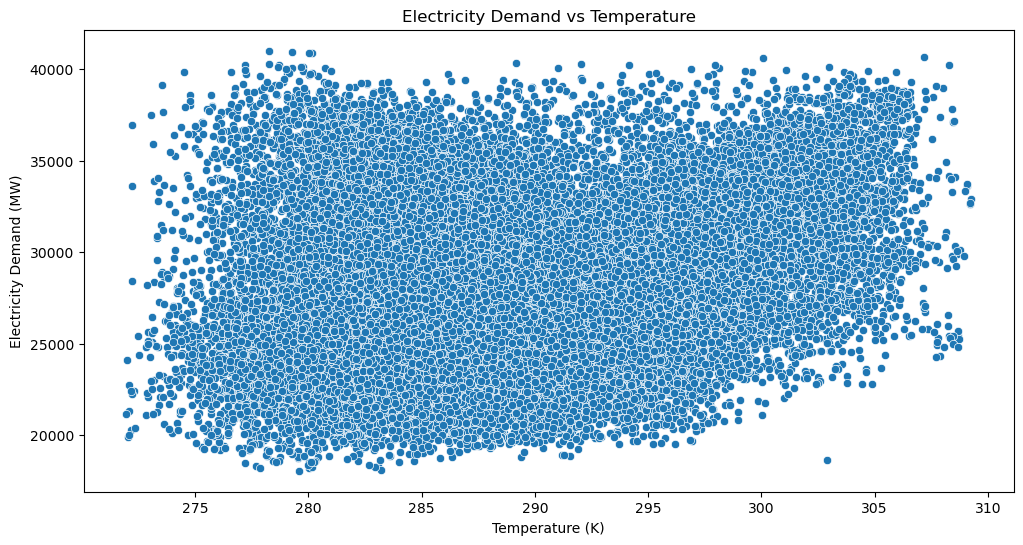

Correlation between temperature and electricity demand: 0.203338692935468
Conclusion: The hypothesis is supported but with a weak correlation. It implies that while temperature may be a factor in electricity demand, it is likely not the only one, and other factors may also play significant roles


In [7]:
# Hypothesis 1: Temperature Effect
# Scatter plot of temperature vs electricity demand
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp', y='total load actual', data=data)
plt.title('Electricity Demand vs Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Electricity Demand (MW)')
plt.show()
correlation_temp_demand = data['temp'].corr(data['total load actual'])
print('Correlation between temperature and electricity demand:', correlation_temp_demand)
print('Conclusion: The hypothesis is supported but with a weak correlation. It implies that while temperature may be a factor in electricity demand, it is likely not the only one, and other factors may also play significant roles')

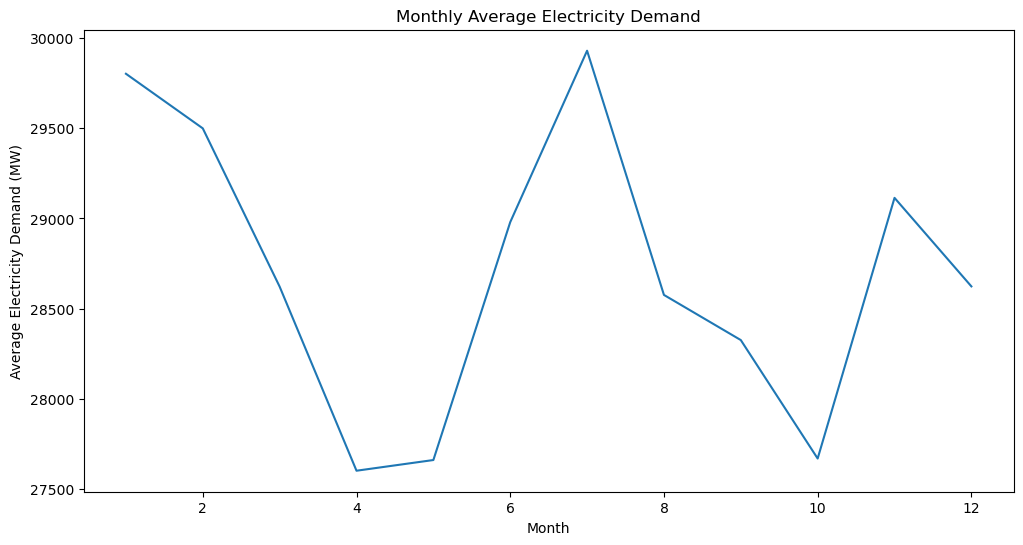

Conclusion: The data supports the hypothesis, with demand peaking at times consistent with extreme temperatures, which are common in peak seasons.


In [8]:
# Hypothesis 2: Seasonality
# Calculate monthly average electricity demand
monthly_demand = data.groupby('month')['total load actual'].mean().reset_index()

# Line plot of monthly average electricity demand
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='total load actual', data=monthly_demand)
plt.title('Monthly Average Electricity Demand')
plt.xlabel('Month')
plt.ylabel('Average Electricity Demand (MW)')
plt.show()
print('Conclusion: The data supports the hypothesis, with demand peaking at times consistent with extreme temperatures, which are common in peak seasons.')

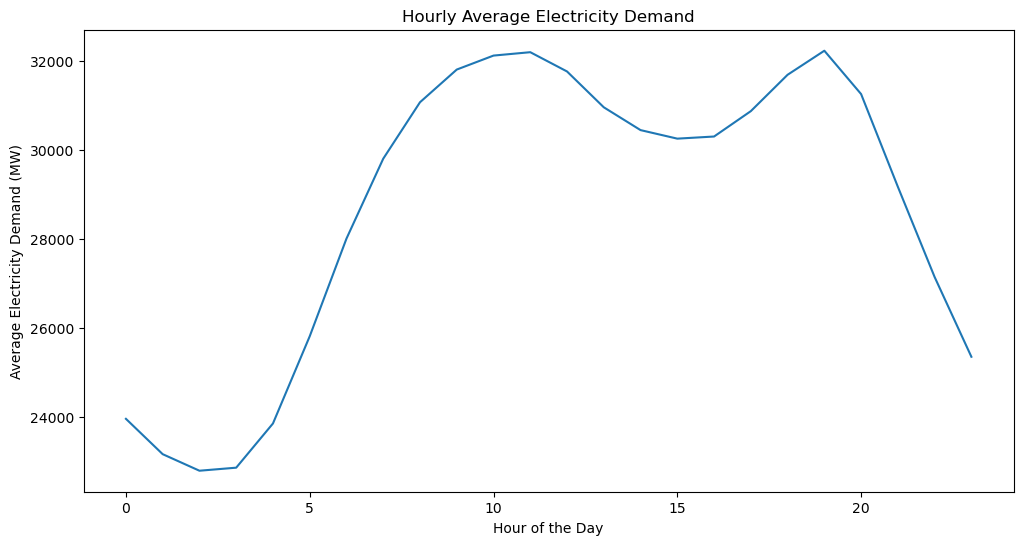

Conclusion: The visual evidence from the graph corroborates the hypothesis of a time of day effect on electricity demand, with distinct peaks and troughs corresponding to different hours of the day. This suggests that electricity usage is higher during evening hours and lower during early mornings.


In [9]:
# Hypothesis 3: Time of Day Effect
# Calculate hourly average electricity demand
hourly_demand = data.groupby('hour')['total load actual'].mean().reset_index()

# Line plot of hourly average electricity demand
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='total load actual', data=hourly_demand)
plt.title('Hourly Average Electricity Demand')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Electricity Demand (MW)')
plt.show()
print('Conclusion: The visual evidence from the graph corroborates the hypothesis of a time of day effect on electricity demand, with distinct peaks and troughs corresponding to different hours of the day. This suggests that electricity usage is higher during evening hours and lower during early mornings.')

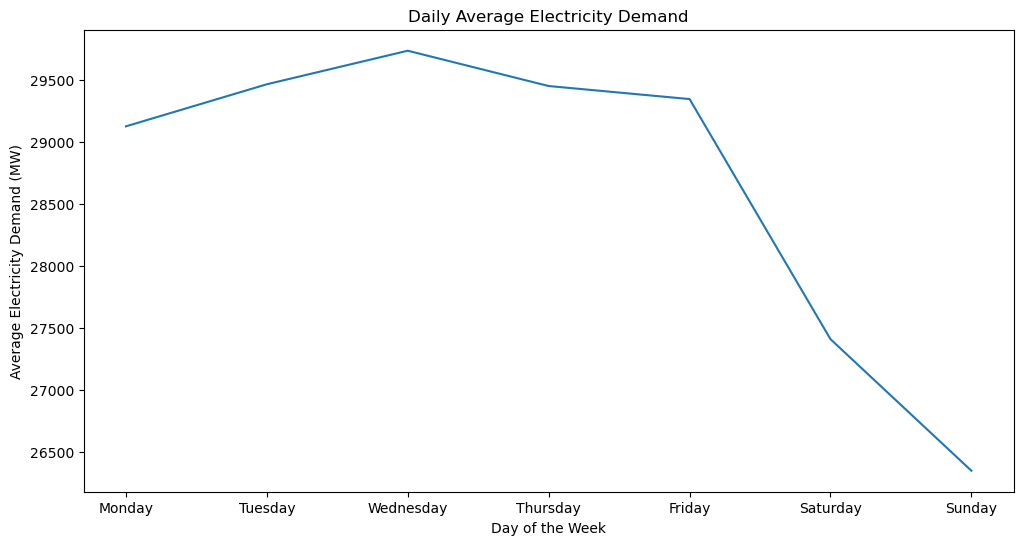

Conclusion: The evidence supports the hypothesis that electricity demand patterns differ between weekdays and weekends, likely due to variations in commercial and residential activity. The higher demand on weekdays can be attributed to business operations and increased residential usage, while the lower demand on weekends suggests reduced commercial activity and possible changes in residential patterns.


In [10]:
# Hypothesis 4: Day of Week Effect
# Calculate daily average electricity demand
daily_demand = data.groupby('day_of_week')['total load actual'].mean().reset_index()

# Line plot of daily average electricity demand
plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_week', y='total load actual', data=daily_demand)
plt.title('Daily Average Electricity Demand')
plt.xlabel('Day of the Week')
plt.ylabel('Average Electricity Demand (MW)')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()
print('Conclusion: The evidence supports the hypothesis that electricity demand patterns differ between weekdays and weekends, likely due to variations in commercial and residential activity. The higher demand on weekdays can be attributed to business operations and increased residential usage, while the lower demand on weekends suggests reduced commercial activity and possible changes in residential patterns.')


<Figure size 1200x600 with 0 Axes>

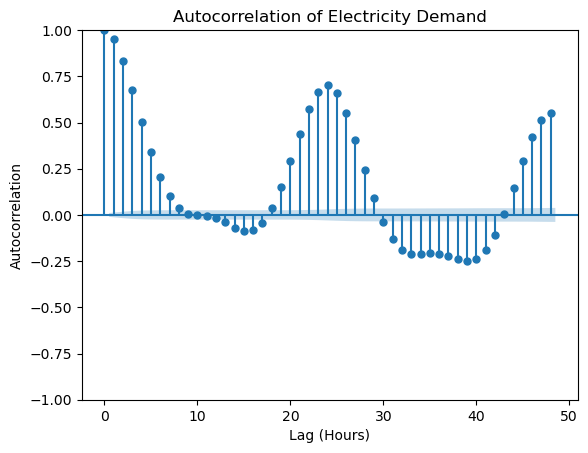

In [11]:
# Hypothesis 5: Lagged Demand Effect
# Plot ACF for electricity demand
plt.figure(figsize=(12, 6))
plot_acf(data['total load actual'], lags=48)
plt.title('Autocorrelation of Electricity Demand')
plt.xlabel('Lag (Hours)')
plt.ylabel('Autocorrelation')
plt.show()

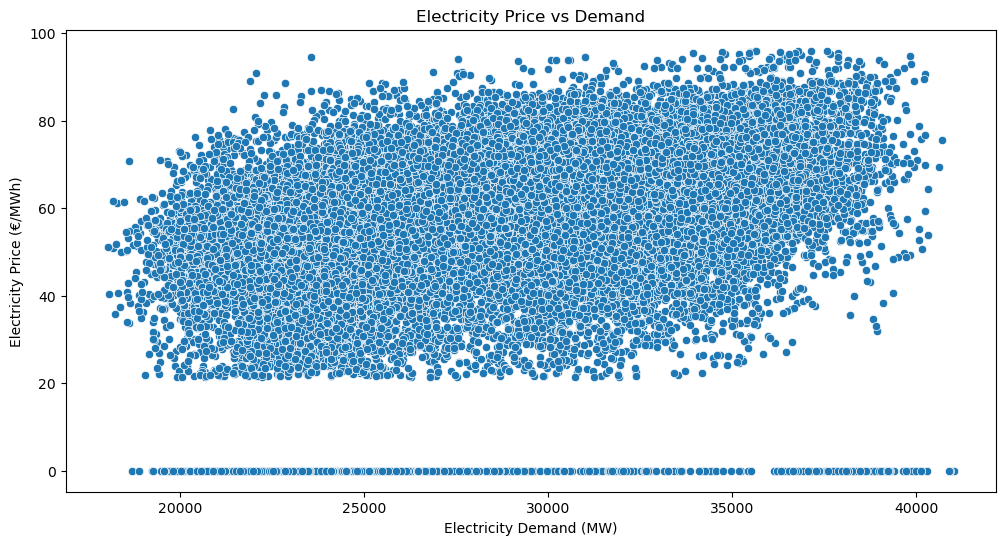

Correlation between electricity price and demand: 0.3800691485588879
Conclusion: The evidence supports the hypothesis that higher electricity demand is associated with higher prices. This relationship is crucial for energy economics and can inform pricing strategies for utility companies.


In [12]:
# Hypothesis 6: Demand-Price Relationship
# Scatter plot of electricity price vs demand
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total load actual', y='price actual', data=data)
plt.title('Electricity Price vs Demand')
plt.xlabel('Electricity Demand (MW)')
plt.ylabel('Electricity Price (€/MWh)')
plt.show()

# Correlation between electricity price and demand
correlation_demand_price = data['total load actual'].corr(data['price actual'])
print('Correlation between electricity price and demand:', correlation_demand_price)
print('Conclusion: The evidence supports the hypothesis that higher electricity demand is associated with higher prices. This relationship is crucial for energy economics and can inform pricing strategies for utility companies.')

<Figure size 1200x600 with 0 Axes>

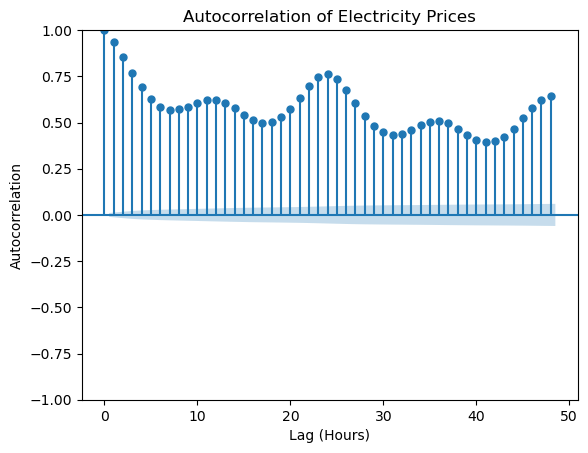

In [13]:
# Hypothesis 7: Lagged Price Effect
# Autocorrelation plot of electricity prices
plt.figure(figsize=(12, 6))
plot_acf(data['price actual'], lags=48)
plt.title('Autocorrelation of Electricity Prices')
plt.xlabel('Lag (Hours)')
plt.ylabel('Autocorrelation')
plt.show()

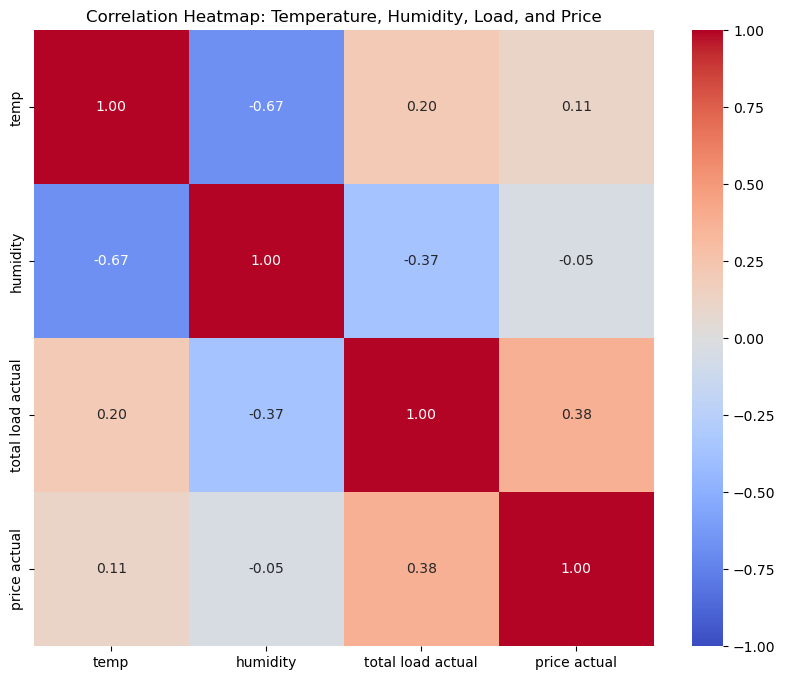

In [14]:
# Selecting specific columns of interest
columns_of_interest = ['temp', 'humidity', 'total load actual', 'price actual']
subset_data = data[columns_of_interest]

# Calculate correlation matrix
correlation_matrix = subset_data.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Temperature, Humidity, Load, and Price')
plt.show()

# Predicting Models

# Linear Regression

## Total Load Actual 

In [32]:
# Features for 'total load actual' prediction
selected_features_load = [
    'generation hydro water reservoir',
    'generation fossil oil',
    'price day ahead',
    'forecast solar day ahead',
    'generation fossil hard coal',
    'generation solar',
    'generation hydro pumped storage consumption',
    'price actual',
    'humidity',
    'generation fossil brown coal/lignite',
    'is_weekend',
    'temp_cubed',
    'temp_squared',
    'temp_min',
    'temperature',
    'temp',
    'temp_max',
    'wind_speed',
    'generation other renewable',
    'generation fossil gas',
    'temp_lag_1',
    'temp_lag_2',
    'generation hydro run-of-river and poundage',
    'generation other',
    'generation nuclear',
    'wind_deg',
    'generation waste',
    'generation biomass',
    'forecast wind onshore day ahead',
    'generation wind onshore','demand_peak_offpeak_peak','price_peak_offpeak_peak'
]

def calculate_metrics(y_true, y_pred, X):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Filter out near-zero values in y_true
    mask = y_true > 1e-10
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Check if there are valid predictions
    if len(y_true_filtered) == 0 or len(y_pred_filtered) == 0:
        mape = np.nan  # Handle case where no valid values exist
    else:
        # Calculate MAPE
        mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    
    # Calculate R-squared and adjusted R-squared
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X.shape[1] - 1)
    
    return mae, rmse, mape, r2, adjusted_r2




# Define features (X) and target (y) for 'total load actual'
X_load = data[selected_features_load]
y_load = data['total load actual']

# Split the dataset into training, validation, and test sets
X_train_load, X_temp_load, y_train_load, y_temp_load = train_test_split(X_load, y_load, test_size=0.3, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp_load, y_temp_load, test_size=0.5, random_state=42)

# Fit the linear regression model
model_load = LinearRegression()
model_load.fit(X_train_load, y_train_load)

# Predict on validation and test sets
y_val_pred_load = model_load.predict(X_val_load)
y_test_pred_load = model_load.predict(X_test_load)

# Validation metrics
val_mae_load, val_rmse_load, val_mape_load, val_r2_load, val_adjusted_r2_load = calculate_metrics(y_val_load, y_val_pred_load, X_val_load)
print(f'Validation Metrics for Total Load Actual:')
print(f'MAE: {val_mae_load}')
print(f'RMSE: {val_rmse_load}')
print(f'MAPE: {val_mape_load}%')
print(f'R²: {val_r2_load}')
print(f'Adjusted R²: {val_adjusted_r2_load}')

# Test metrics
test_mae_load, test_rmse_load, test_mape_load, test_r2_load, test_adjusted_r2_load = calculate_metrics(y_test_load, y_test_pred_load, X_test_load)
print(f'Test Metrics for Total Load Actual:')
print(f'MAE: {test_mae_load}')
print(f'RMSE: {test_rmse_load}')
print(f'MAPE: {test_mape_load}%')
print(f'R²: {test_r2_load}')
print(f'Adjusted R²: {test_adjusted_r2_load}')


Validation Metrics for Total Load Actual:
MAE: 1639.0372877847085
RMSE: 2147.823340969088
MAPE: 5.825267713005014%
R²: 0.7780545052321751
Adjusted R²: 0.7766957419200323
Test Metrics for Total Load Actual:
MAE: 1693.6033427786388
RMSE: 2250.5034130640743
MAPE: 5.998158441663523%
R²: 0.7555058341534769
Adjusted R²: 0.7540090265569419


## Price Actual 

In [33]:
# Features for 'price actual' prediction


# Combine both lists
selected_features_price =['generation hydro water reservoir',
    'generation fossil oil',
    'forecast solar day ahead',
    'generation fossil hard coal',
    'generation solar',
    'generation hydro pumped storage consumption',
    'humidity',
    'generation fossil brown coal/lignite',
    'is_weekend',
    'temp_cubed',
    'temp_squared',
    'temp_min',
    'temperature',
    'temp',
    'temp_max',
    'wind_speed',
    'generation other renewable',
    'generation fossil gas',
    'temp_lag_1',
    'temp_lag_2',
    'generation hydro run-of-river and poundage',
    'generation other',
    'generation nuclear',
    'wind_deg',
    'generation waste',
    'generation biomass',
    'forecast wind onshore day ahead',
    'generation wind onshore',
    'demand_peak_offpeak_peak',
    'price_peak_offpeak_peak'
]





# Define features (X) and target (y) for 'price actual'
X_price = data[selected_features_price]
y_price = data['price actual']

# Split the dataset into training, validation, and test sets
X_train_price, X_temp_price, y_train_price, y_temp_price = train_test_split(X_price, y_price, test_size=0.3, random_state=42)
X_val_price, X_test_price, y_val_price, y_test_price = train_test_split(X_temp_price, y_temp_price, test_size=0.5, random_state=42)

# Fit the linear regression model
model_price = LinearRegression()
model_price.fit(X_train_price, y_train_price)

# Predict on validation and test sets
y_val_pred_price = model_price.predict(X_val_price)
y_test_pred_price = model_price.predict(X_test_price)

# Validation metrics
val_mae_price, val_rmse_price, val_mape_price, val_r2_price, val_adjusted_r2_price = calculate_metrics(y_val_price, y_val_pred_price, X_val_price)
print(f'Validation Metrics for Price Actual:')
print(f'MAE: {val_mae_price}')
print(f'RMSE: {val_rmse_price}')
print(f'MAPE: {val_mape_price}%')
print(f'R²: {val_r2_price}')
print(f'Adjusted R²: {val_adjusted_r2_price}')

# Test metrics
test_mae_price, test_rmse_price, test_mape_price, test_r2_price, test_adjusted_r2_price = calculate_metrics(y_test_price, y_test_pred_price, X_test_price)
print(f'Test Metrics for Price Actual:')
print(f'MAE: {test_mae_price}')
print(f'RMSE: {test_rmse_price}')
print(f'MAPE: {test_mape_price}%')
print(f'R²: {test_r2_price}')
print(f'Adjusted R²: {test_adjusted_r2_price}')


Validation Metrics for Price Actual:
MAE: 8.88920506694267
RMSE: 12.514329508559703
MAPE: 15.158124153715896%
R²: 0.32800049664017683
Adjusted R²: 0.324145077802771
Test Metrics for Price Actual:
MAE: 9.161063600093463
RMSE: 12.6693892322397
MAPE: 15.405941016270452%
R²: 0.33250748161223886
Adjusted R²: 0.32867792040519495


# Random Forest

## Total Load Actual

In [17]:

# Define features (X) and target (y) for 'total load actual'
X_load = data[selected_features_load]
y_load = data['total load actual']

# Split the dataset into training, validation, and test sets
X_train_load, X_temp_load, y_train_load, y_temp_load = train_test_split(X_load, y_load, test_size=0.3, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp_load, y_temp_load, test_size=0.5, random_state=42)

# Initialize the Random Forest model
rf_model_load = RandomForestRegressor(random_state=42)

# Fit the model
rf_model_load.fit(X_train_load, y_train_load)

# Predict on validation and test sets
y_val_pred_rf_load = rf_model_load.predict(X_val_load)
y_test_pred_rf_load = rf_model_load.predict(X_test_load)

# Calculate metrics for validation set
val_mae_rf_load, val_rmse_rf_load, val_mape_rf_load, val_r2_rf_load, val_adjusted_r2_rf_load = calculate_metrics(y_val_load, y_val_pred_rf_load, X_val_load)
print(f'Validation Metrics for Random Forest - Total Load Actual:')
print(f'MAE: {val_mae_rf_load}')
print(f'RMSE: {val_rmse_rf_load}')
print(f'MAPE: {val_mape_rf_load}%')
print(f'R²: {val_r2_rf_load}')
print(f'Adjusted R²: {val_adjusted_r2_rf_load}')

# Calculate metrics for test set
test_mae_rf_load, test_rmse_rf_load, test_mape_rf_load, test_r2_rf_load, test_adjusted_r2_rf_load = calculate_metrics(y_test_load, y_test_pred_rf_load, X_test_load)
print(f'Test Metrics for Random Forest - Total Load Actual:')
print(f'MAE: {test_mae_rf_load}')
print(f'RMSE: {test_rmse_rf_load}')
print(f'MAPE: {test_mape_rf_load}%')
print(f'R²: {test_r2_rf_load}')
print(f'Adjusted R²: {test_adjusted_r2_rf_load}')


Validation Metrics for Random Forest - Total Load Actual:
MAE: 791.4770407957719
RMSE: 1073.0578930118897
MAPE: 2.8148053336255767%
R²: 0.9446018164004598
Adjusted R²: 0.9442626654773327
Test Metrics for Random Forest - Total Load Actual:
MAE: 826.4561306485502
RMSE: 1107.4328310895821
MAPE: 2.9379647107796574%
R²: 0.9407969695662277
Adjusted R²: 0.9404345251480374


## Price Actual

In [18]:

# Define features (X) and target (y) for 'price actual'
X_price = data[selected_features_price]
y_price = data['price actual']

# Split the dataset into training, validation, and test sets
X_train_price, X_temp_price, y_train_price, y_temp_price = train_test_split(X_price, y_price, test_size=0.3, random_state=42)
X_val_price, X_test_price, y_val_price, y_test_price = train_test_split(X_temp_price, y_temp_price, test_size=0.5, random_state=42)

# Initialize the Random Forest model
rf_model_price = RandomForestRegressor(random_state=42)

# Fit the model
rf_model_price.fit(X_train_price, y_train_price)

# Predict on validation and test sets
y_val_pred_rf_price = rf_model_price.predict(X_val_price)
y_test_pred_rf_price = rf_model_price.predict(X_test_price)

# Calculate metrics for validation set
val_mae_rf_price, val_rmse_rf_price, val_mape_rf_price, val_r2_rf_price, val_adjusted_r2_rf_price = calculate_metrics(y_val_price, y_val_pred_rf_price, X_val_price)
print(f'Validation Metrics for Random Forest - Price Actual:')
print(f'MAE: {val_mae_rf_price}')
print(f'RMSE: {val_rmse_rf_price}')
print(f'MAPE: {val_mape_rf_price}%')
print(f'R²: {val_r2_rf_price}')
print(f'Adjusted R²: {val_adjusted_r2_rf_price}')

# Calculate metrics for test set
test_mae_rf_price, test_rmse_rf_price, test_mape_rf_price, test_r2_rf_price, test_adjusted_r2_rf_price = calculate_metrics(y_test_price, y_test_pred_rf_price, X_test_price)
print(f'Test Metrics for Random Forest - Price Actual:')
print(f'MAE: {test_mae_rf_price}')
print(f'RMSE: {test_rmse_rf_price}')
print(f'MAPE: {test_mape_rf_price}%')
print(f'R²: {test_r2_rf_price}')
print(f'Adjusted R²: {test_adjusted_r2_rf_price}')


Validation Metrics for Random Forest - Price Actual:
MAE: 4.244571463878327
RMSE: 6.663557221681065
MAPE: 7.29424162095893%
R²: 0.8094688261774206
Adjusted R²: 0.8083757041245084
Test Metrics for Random Forest - Price Actual:
MAE: 4.375367756653993
RMSE: 7.109473848195442
MAPE: 7.309361238759447%
R²: 0.7898110084122368
Adjusted R²: 0.788605104846042


# Gradient Boosting

## Total Load Actual

In [19]:
# Initialize the Gradient Boosting model
gb_model_load = GradientBoostingRegressor(random_state=42)

# Fit the model
gb_model_load.fit(X_train_load, y_train_load)

# Predict on validation and test sets
y_val_pred_gb_load = gb_model_load.predict(X_val_load)
y_test_pred_gb_load = gb_model_load.predict(X_test_load)

# Calculate metrics for validation set
val_mae_gb_load, val_rmse_gb_load, val_mape_gb_load, val_r2_gb_load, val_adjusted_r2_gb_load = calculate_metrics(y_val_load, y_val_pred_gb_load, X_val_load)
print(f'Validation Metrics for Gradient Boosting - Total Load Actual:')
print(f'MAE: {val_mae_gb_load}')
print(f'RMSE: {val_rmse_gb_load}')
print(f'MAPE: {val_mape_gb_load}%')
print(f'R²: {val_r2_gb_load}')
print(f'Adjusted R²: {val_adjusted_r2_gb_load}')

# Calculate metrics for test set
test_mae_gb_load, test_rmse_gb_load, test_mape_gb_load, test_r2_gb_load, test_adjusted_r2_gb_load = calculate_metrics(y_test_load, y_test_pred_gb_load, X_test_load)
print(f'Test Metrics for Gradient Boosting - Total Load Actual:')
print(f'MAE: {test_mae_gb_load}')
print(f'RMSE: {test_rmse_gb_load}')
print(f'MAPE: {test_mape_gb_load}%')
print(f'R²: {test_r2_gb_load}')
print(f'Adjusted R²: {test_adjusted_r2_gb_load}')


Validation Metrics for Gradient Boosting - Total Load Actual:
MAE: 1149.6230092795417
RMSE: 1462.1188445266448
MAPE: 4.130172897198987%
R²: 0.8971475674567606
Adjusted R²: 0.8965178988435247
Test Metrics for Gradient Boosting - Total Load Actual:
MAE: 1163.9760681859211
RMSE: 1477.2702981547804
MAPE: 4.168181238340385%
R²: 0.8946513242989519
Adjusted R²: 0.8940063735389684


## Price Actual

In [20]:

# Initialize the Gradient Boosting model
gb_model_price = GradientBoostingRegressor(random_state=42)

# Fit the model
gb_model_price.fit(X_train_price, y_train_price)

# Predict on validation and test sets
y_val_pred_gb_price = gb_model_price.predict(X_val_price)
y_test_pred_gb_price = gb_model_price.predict(X_test_price)

# Calculate metrics for validation set
val_mae_gb_price, val_rmse_gb_price, val_mape_gb_price, val_r2_gb_price, val_adjusted_r2_gb_price = calculate_metrics(y_val_price, y_val_pred_gb_price, X_val_price)
print(f'Validation Metrics for Gradient Boosting - Price Actual:')
print(f'MAE: {val_mae_gb_price}')
print(f'RMSE: {val_rmse_gb_price}')
print(f'MAPE: {val_mape_gb_price}%')
print(f'R²: {val_r2_gb_price}')
print(f'Adjusted R²: {val_adjusted_r2_gb_price}')

# Calculate metrics for test set
test_mae_gb_price, test_rmse_gb_price, test_mape_gb_price, test_r2_gb_price, test_adjusted_r2_gb_price = calculate_metrics(y_test_price, y_test_pred_gb_price, X_test_price)
print(f'Test Metrics for Gradient Boosting - Price Actual:')
print(f'MAE: {test_mae_gb_price}')
print(f'RMSE: {test_rmse_gb_price}')
print(f'MAPE: {test_mape_gb_price}%')
print(f'R²: {test_r2_gb_price}')
print(f'Adjusted R²: {test_adjusted_r2_gb_price}')


Validation Metrics for Gradient Boosting - Price Actual:
MAE: 7.371572824142188
RMSE: 10.346635961997588
MAPE: 12.717579738351056%
R²: 0.5406411179156618
Adjusted R²: 0.5380056682192513
Test Metrics for Gradient Boosting - Price Actual:
MAE: 7.4225511593088935
RMSE: 10.50240109101139
MAPE: 12.55288964389539%
R²: 0.5413174219148149
Adjusted R²: 0.5386858523331444


# Random Forest Parameter Tuning

## Total Load Actual

In [21]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_rf_load = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': [ 'sqrt', 'log2',None]
}

# Initialize the Random Forest model
rf_model_load = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf_load = RandomizedSearchCV(estimator=rf_model_load, param_distributions=param_dist_rf_load, n_iter=30, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search_rf_load.fit(X_train_load, y_train_load)

# Best parameters and best score
print("Best parameters found for Random Forest - Total Load Actual:")
print(random_search_rf_load.best_params_)
print("Best RMSE score found for Random Forest - Total Load Actual:")
print(np.sqrt(-random_search_rf_load.best_score_))

# Predict using the best model
best_rf_model_load = random_search_rf_load.best_estimator_
y_val_pred_rf_load_tuned = best_rf_model_load.predict(X_val_load)
y_test_pred_rf_load_tuned = best_rf_model_load.predict(X_test_load)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, X):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    return mae, rmse, mape, r2, adjusted_r2

# Calculate metrics for validation set with tuned model
val_mae_rf_load_tuned, val_rmse_rf_load_tuned, val_mape_rf_load_tuned, val_r2_rf_load_tuned, val_adjusted_r2_rf_load_tuned = calculate_metrics(y_val_load, y_val_pred_rf_load_tuned, X_val_load)
print(f'Validation Metrics for Tuned Random Forest - Total Load Actual:')
print(f'MAE: {val_mae_rf_load_tuned}')
print(f'RMSE: {val_rmse_rf_load_tuned}')
print(f'MAPE: {val_mape_rf_load_tuned}%')
print(f'R²: {val_r2_rf_load_tuned}')
print(f'Adjusted R²: {val_adjusted_r2_rf_load_tuned}')

# Calculate metrics for test set with tuned model
test_mae_rf_load_tuned, test_rmse_rf_load_tuned, test_mape_rf_load_tuned, test_r2_rf_load_tuned, test_adjusted_r2_rf_load_tuned = calculate_metrics(y_test_load, y_test_pred_rf_load_tuned, X_test_load)
print(f'Test Metrics for Tuned Random Forest - Total Load Actual:')
print(f'MAE: {test_mae_rf_load_tuned}')
print(f'RMSE: {test_rmse_rf_load_tuned}')
print(f'MAPE: {test_mape_rf_load_tuned}%')
print(f'R²: {test_r2_rf_load_tuned}')
print(f'Adjusted R²: {test_adjusted_r2_rf_load_tuned}')


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found for Random Forest - Total Load Actual:
{'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best RMSE score found for Random Forest - Total Load Actual:
1204.3271215929856
Validation Metrics for Tuned Random Forest - Total Load Actual:
MAE: 801.3855555116428
RMSE: 1084.4198348316768
MAPE: 2.8497069604196157%
R²: 0.9434224517655618
Adjusted R²: 0.9430760807030973
Test Metrics for Tuned Random Forest - Total Load Actual:
MAE: 835.7118318831899
RMSE: 1115.1523010454823
MAPE: 2.9702011769674534%
R²: 0.9399687317905409
Adjusted R²: 0.939601216852201


## Price Actual

In [28]:
# Define the parameter distribution
param_dist_rf_price = {
    'n_estimators': randint(50, 200),  # Random values between 50 and 200
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 11),  # Random values between 2 and 10
    'min_samples_leaf': randint(1, 5),  # Random values between 1 and 4
    'max_features': ['sqrt', 'log2', None]  # Corrected values
}

# Initialize the Random Forest model
rf_model_price = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf_price = RandomizedSearchCV(estimator=rf_model_price, param_distributions=param_dist_rf_price, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search_rf_price.fit(X_train_price, y_train_price)

print("Best parameters found for Random Forest - Price Actual:")
print(random_search_rf_price.best_params_)
print("Best RMSE score found for Random Forest - Price Actual:")
print(np.sqrt(-random_search_rf_price.best_score_))

# Predict using the best model
best_rf_model_price = random_search_rf_price.best_estimator_
y_val_pred_rf_price_tuned = best_rf_model_price.predict(X_val_price)
y_test_pred_rf_price_tuned = best_rf_model_price.predict(X_test_price)

# Calculate metrics for validation set with tuned model
val_mae_rf_price_tuned, val_rmse_rf_price_tuned, val_mape_rf_price_tuned, val_r2_rf_price_tuned, val_adjusted_r2_rf_price_tuned = calculate_metrics(y_val_price, y_val_pred_rf_price_tuned, X_val_price)
print(f'MAE: {val_mae_rf_price_tuned}')
print(f'RMSE: {val_rmse_rf_price_tuned}')
print(f'MAPE: {val_mape_rf_price_tuned}%')
print(f'R²: {val_r2_rf_price_tuned}')
print(f'Adjusted R²: {val_adjusted_r2_rf_price_tuned}')

# Calculate metrics for test set with tuned model
test_mae_rf_price_tuned, test_rmse_rf_price_tuned, test_mape_rf_price_tuned, test_r2_rf_price_tuned, test_adjusted_r2_rf_price_tuned = calculate_metrics(y_test_price, y_test_pred_rf_price_tuned, X_test_price)
print(f'Test Metrics for Tuned Random Forest - Price Actual:')
print(f'MAE: {test_mae_rf_price_tuned}')
print(f'RMSE: {test_rmse_rf_price_tuned}')
print(f'MAPE: {test_mape_rf_price_tuned}%')
print(f'R²: {test_r2_rf_price_tuned}')
print(f'Adjusted R²: {test_adjusted_r2_rf_price_tuned}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found for Random Forest - Price Actual:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 178}
Best RMSE score found for Random Forest - Price Actual:
7.6594655477238565
MAE: 4.278345111568976
RMSE: 6.744802798583942
MAPE: 7.34892788667501%
R²: 0.8047943907007853
Adjusted R²: 0.8036744503146739
Test Metrics for Tuned Random Forest - Price Actual:
MAE: 4.4069424732716325
RMSE: 7.187836559944746
MAPE: 7.331828698481877%
R²: 0.7851519425787503
Adjusted R²: 0.7839193088586054


# Gradient Boosting Parameter Tuning

## Total Load Actual

In [29]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_gb_load = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': [ 'sqrt', 'log2',None]
}

# Initialize the Gradient Boosting model
gb_model_load = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb_load = RandomizedSearchCV(estimator=gb_model_load, param_distributions=param_dist_gb_load, n_iter=30, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search_gb_load.fit(X_train_load, y_train_load)

# Best parameters and best score
print("Best parameters found for Gradient Boosting - Total Load Actual:")
print(random_search_gb_load.best_params_)
print("Best RMSE score found for Gradient Boosting - Total Load Actual:")
print(np.sqrt(-random_search_gb_load.best_score_))

# Predict using the best model
best_gb_model_load = random_search_gb_load.best_estimator_
y_val_pred_gb_load_tuned = best_gb_model_load.predict(X_val_load)
y_test_pred_gb_load_tuned = best_gb_model_load.predict(X_test_load)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, X):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X.shape[1]-1)
    return mae, rmse, mape, r2, adjusted_r2

# Calculate metrics for validation set with tuned model
val_mae_gb_load_tuned, val_rmse_gb_load_tuned, val_mape_gb_load_tuned, val_r2_gb_load_tuned, val_adjusted_r2_gb_load_tuned = calculate_metrics(y_val_load, y_val_pred_gb_load_tuned, X_val_load)
print(f'Validation Metrics for Tuned Gradient Boosting - Total Load Actual:')
print(f'MAE: {val_mae_gb_load_tuned}')
print(f'RMSE: {val_rmse_gb_load_tuned}')
print(f'MAPE: {val_mape_gb_load_tuned}%')
print(f'R²: {val_r2_gb_load_tuned}')
print(f'Adjusted R²: {val_adjusted_r2_gb_load_tuned}')

# Calculate metrics for test set with tuned model
test_mae_gb_load_tuned, test_rmse_gb_load_tuned, test_mape_gb_load_tuned, test_r2_gb_load_tuned, test_adjusted_r2_gb_load_tuned = calculate_metrics(y_test_load, y_test_pred_gb_load_tuned, X_test_load)
print(f'Test Metrics for Tuned Gradient Boosting - Total Load Actual:')
print(f'MAE: {test_mae_gb_load_tuned}')
print(f'RMSE: {test_rmse_gb_load_tuned}')
print(f'MAPE: {test_mape_gb_load_tuned}%')
print(f'R²: {test_r2_gb_load_tuned}')
print(f'Adjusted R²: {test_adjusted_r2_gb_load_tuned}')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found for Gradient Boosting - Total Load Actual:
{'learning_rate': 0.19727005942368125, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 110}
Best RMSE score found for Gradient Boosting - Total Load Actual:
1023.7090871873244
Validation Metrics for Tuned Gradient Boosting - Total Load Actual:
MAE: 730.4689077661233
RMSE: 958.3378866408312
MAPE: 2.59657681427573%
R²: 0.9558138122093665
Adjusted R²: 0.9555433017809563
Test Metrics for Tuned Gradient Boosting - Total Load Actual:
MAE: 739.2993386092288
RMSE: 975.0946730621703
MAPE: 2.628868578436118%
R²: 0.9541010536181888
Adjusted R²: 0.9538200575814147


## Price Actual 

In [34]:
# Define the parameter distributions
param_dist_gb_price = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.5),
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2',None]
}

# Initialize the Gradient Boosting model
gb_model_price = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb_price = RandomizedSearchCV(estimator=gb_model_price, param_distributions=param_dist_gb_price, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search_gb_price.fit(X_train_price, y_train_price)

print("Best parameters found for Gradient Boosting - Price Actual:")
print(random_search_gb_price.best_params_)
print("Best RMSE score found for Gradient Boosting - Price Actual:")
print(np.sqrt(-random_search_gb_price.best_score_))

# Predict using the best model
best_gb_model_price = random_search_gb_price.best_estimator_
y_val_pred_gb_price_tuned = best_gb_model_price.predict(X_val_price)
y_test_pred_gb_price_tuned = best_gb_model_price.predict(X_test_price)

# Calculate metrics for validation set with tuned model
val_mae_gb_price_tuned, val_rmse_gb_price_tuned, val_mape_gb_price_tuned, val_r2_gb_price_tuned, val_adjusted_r2_gb_price_tuned = calculate_metrics(y_val_price, y_val_pred_gb_price_tuned, X_val_price)
print(f'Validation Metrics for Tuned Gradient Boosting - Price Actual:')
print(f'MAE: {val_mae_gb_price_tuned}')
print(f'RMSE: {val_rmse_gb_price_tuned}')
print(f'MAPE: {val_mape_gb_price_tuned}%')
print(f'R²: {val_r2_gb_price_tuned}')
print(f'Adjusted R²: {val_adjusted_r2_gb_price_tuned}')

# Calculate metrics for test set with tuned model
test_mae_gb_price_tuned, test_rmse_gb_price_tuned, test_mape_gb_price_tuned, test_r2_gb_price_tuned, test_adjusted_r2_gb_price_tuned = calculate_metrics(y_test_price, y_test_pred_gb_price_tuned, X_test_price)
print(f'Test Metrics for Tuned Gradient Boosting - Price Actual:')
print(f'MAE: {test_mae_gb_price_tuned}')
print(f'RMSE: {test_rmse_gb_price_tuned}')
print(f'MAPE: {test_mape_gb_price_tuned}%')
print(f'R²: {test_r2_gb_price_tuned}')
print(f'Adjusted R²: {test_adjusted_r2_gb_price_tuned}')



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found for Gradient Boosting - Price Actual:
{'learning_rate': 0.19727005942368125, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 110}
Best RMSE score found for Gradient Boosting - Price Actual:
7.356091074203038
Validation Metrics for Tuned Gradient Boosting - Price Actual:
MAE: 4.669347383458145
RMSE: 6.799714492244078
MAPE: 8.200062432399607%
R²: 0.8016029840109058
Adjusted R²: 0.8004647337757418
Test Metrics for Tuned Gradient Boosting - Price Actual:
MAE: 4.816641651776523
RMSE: 7.368618365313208
MAPE: 8.252979662037168%
R²: 0.7742087161956045
Adjusted R²: 0.7729132986178398


# LSTM Model for Total Load Actual

In [36]:
# Define the scaler
scaler_target = MinMaxScaler()

# Convert Series to numpy arrays and reshape
y_train_load_array = y_train_load.values.reshape(-1, 1)
y_val_load_array = y_val_load.values.reshape(-1, 1)
y_test_load_array = y_test_load.values.reshape(-1, 1)

# Fit the scaler on the training target variable
y_train_load_scaled = scaler_target.fit_transform(y_train_load_array)

# Transform validation and test target variables using the fitted scaler
y_val_load_scaled = scaler_target.transform(y_val_load_array)
y_test_load_scaled = scaler_target.transform(y_test_load_array)

# Reshape the data for LSTM [samples, time_steps, features]
X_train_load_reshaped = X_train_load.values.reshape((X_train_load.shape[0], 1, X_train_load.shape[1])).astype(np.float32)
X_val_load_reshaped = X_val_load.values.reshape((X_val_load.shape[0], 1, X_val_load.shape[1])).astype(np.float32)
X_test_load_reshaped = X_test_load.values.reshape((X_test_load.shape[0], 1, X_test_load.shape[1])).astype(np.float32)

# Define and compile the LSTM model
model_lstm_load = Sequential()
model_lstm_load.add(LSTM(units=50, input_shape=(X_train_load_reshaped.shape[1], X_train_load_reshaped.shape[2])))
model_lstm_load.add(Dense(1))  # Output layer with 1 neuron for regression task
model_lstm_load.compile(optimizer='adam', loss='mse')  # Compile the model

# Fit the LSTM model
model_lstm_load.fit(X_train_load_reshaped, y_train_load_scaled, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_load_reshaped, y_val_load_scaled))

# Predicting on validation and test data with LSTM model
scaled_y_val_pred_lstm_load = model_lstm_load.predict(X_val_load_reshaped)
scaled_y_test_pred_lstm_load = model_lstm_load.predict(X_test_load_reshaped)

# Inverse transform predictions to original scale
y_val_pred_lstm_load = scaler_target.inverse_transform(scaled_y_val_pred_lstm_load)
y_test_pred_lstm_load = scaler_target.inverse_transform(scaled_y_test_pred_lstm_load)

# Ensure y_val_pred_lstm_load and y_test_pred_lstm_load are 1-dimensional
y_val_pred_lstm_load = y_val_pred_lstm_load.reshape(-1)
y_test_pred_lstm_load = y_test_pred_lstm_load.reshape(-1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true > 1e-10
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    if len(y_true_filtered) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_val_load.shape[1] - 1)
    return mae, rmse, mape, r2, adjusted_r2

# Calculate metrics for validation set
val_mae_lstm_load, val_rmse_lstm_load, val_mape_lstm_load, val_r2_lstm_load, val_adjusted_r2_lstm_load = calculate_metrics(y_val_load, y_val_pred_lstm_load)
print(f'Validation Metrics for LSTM - Total Load Actual:')
print(f'MAE: {val_mae_lstm_load}')
print(f'RMSE: {val_rmse_lstm_load}')
print(f'MAPE: {val_mape_lstm_load}')
print(f'R2: {val_r2_lstm_load}')
print(f'Adjusted R2: {val_adjusted_r2_lstm_load}')

# Calculate metrics for test set
test_mae_lstm_load, test_rmse_lstm_load, test_mape_lstm_load, test_r2_lstm_load, test_adjusted_r2_lstm_load = calculate_metrics(y_test_load, y_test_pred_lstm_load)
print(f'Test Metrics for LSTM - Total Load Actual:')
print(f'MAE: {test_mae_lstm_load}')
print(f'RMSE: {test_rmse_lstm_load}')
print(f'MAPE: {test_mape_lstm_load}')
print(f'R2: {test_r2_lstm_load}')
print(f'Adjusted R2: {test_adjusted_r2_lstm_load}')

Epoch 1/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - loss: 0.1385 - val_loss: 0.0394
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 0.0397 - val_loss: 0.0394
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.0399 - val_loss: 0.0394
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.0396 - val_loss: 0.0396
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 0.0395 - val_loss: 0.0394
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 0.0396 - val_loss: 0.0394
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.0400 - val_loss: 0.0394
Epoch 8/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - loss: 0.0394 - val_loss: 0.0399
Epoch 9/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.0403 - val_loss: 0.0397
Epoch 10/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - loss: 0.0396 - val_loss: 0.0395
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
Validation Metrics for LSTM - Total Load Actua

# LSTM Model for Price Actual

In [37]:

# Define the scaler
scaler_price = MinMaxScaler()

# Convert Series to numpy arrays and reshape for target variable
y_train_price_array = y_train_price.values.reshape(-1, 1)
y_val_price_array = y_val_price.values.reshape(-1, 1)
y_test_price_array = y_test_price.values.reshape(-1, 1)

# Fit the scaler on the training target variable
y_train_price_scaled = scaler_price.fit_transform(y_train_price_array)

# Transform validation and test target variables using the fitted scaler
y_val_price_scaled = scaler_price.transform(y_val_price_array)
y_test_price_scaled = scaler_price.transform(y_test_price_array)

# Reshape the data for LSTM [samples, time_steps, features]
X_train_price_reshaped = X_train_price.values.reshape((X_train_price.shape[0], 1, X_train_price.shape[1])).astype(np.float32)
X_val_price_reshaped = X_val_price.values.reshape((X_val_price.shape[0], 1, X_val_price.shape[1])).astype(np.float32)
X_test_price_reshaped = X_test_price.values.reshape((X_test_price.shape[0], 1, X_test_price.shape[1])).astype(np.float32)

# Define and compile the LSTM model
model_lstm_price = Sequential()
model_lstm_price.add(LSTM(units=50, input_shape=(X_train_price_reshaped.shape[1], X_train_price_reshaped.shape[2])))
model_lstm_price.add(Dense(1))  # Output layer with 1 neuron for regression task
model_lstm_price.compile(optimizer='adam', loss='mse')  # Compile the model

# Fit the LSTM model
model_lstm_price.fit(X_train_price_reshaped, y_train_price_scaled, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_price_reshaped, y_val_price_scaled))

# Predicting on validation and test data with LSTM model
scaled_y_val_pred_lstm_price = model_lstm_price.predict(X_val_price_reshaped)
scaled_y_test_pred_lstm_price = model_lstm_price.predict(X_test_price_reshaped)

# Inverse transform predictions to original scale
y_val_pred_lstm_price = scaler_price.inverse_transform(scaled_y_val_pred_lstm_price)
y_test_pred_lstm_price = scaler_price.inverse_transform(scaled_y_test_pred_lstm_price)

# Ensure y_val_pred_lstm_price and y_test_pred_lstm_price are 1-dimensional
y_val_pred_lstm_price = y_val_pred_lstm_price.reshape(-1)
y_test_pred_lstm_price = y_test_pred_lstm_price.reshape(-1)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true > 1e-10
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    if len(y_true_filtered) == 0:
        mape = np.nan
    else:
        mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_val_price.shape[1] - 1)
    return mae, rmse, mape, r2, adjusted_r2

# Calculate metrics for validation set
val_mae_lstm_price, val_rmse_lstm_price, val_mape_lstm_price, val_r2_lstm_price, val_adjusted_r2_lstm_price = calculate_metrics(y_val_price, y_val_pred_lstm_price)
print(f'Validation Metrics for LSTM - Price Actual:')
print(f'MAE: {val_mae_lstm_price}')
print(f'RMSE: {val_rmse_lstm_price}')
print(f'MAPE: {val_mape_lstm_price}')
print(f'R2: {val_r2_lstm_price}')
print(f'Adjusted R2: {val_adjusted_r2_lstm_price}')

# Calculate metrics for test set
test_mae_lstm_price, test_rmse_lstm_price, test_mape_lstm_price, test_r2_lstm_price, test_adjusted_r2_lstm_price = calculate_metrics(y_test_price, y_test_pred_lstm_price)
print(f'Test Metrics for LSTM - Price Actual:')
print(f'MAE: {test_mae_lstm_price}')
print(f'RMSE: {test_rmse_lstm_price}')
print(f'MAPE: {test_mape_lstm_price}')
print(f'R2: {test_r2_lstm_price}')
print(f'Adjusted R2: {test_adjusted_r2_lstm_price}')

Epoch 1/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step - loss: 0.0460 - val_loss: 0.0253
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - loss: 0.0256 - val_loss: 0.0255
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.0254 - val_loss: 0.0254
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.0250 - val_loss: 0.0253
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 0.0252 - val_loss: 0.0254
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - loss: 0.0252 - val_loss: 0.0254
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.0251 - val_loss: 0.0254
Epoch 8/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 0.0254 - val_loss: 0.0253
Epoch 9/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.0255 - val_loss: 0.0253
Epoch 10/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - loss: 0.0255 - val_loss: 0.0253
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
Validation Metrics for LSTM - Price Actual:
MA

# Table

In [38]:


# Define the metrics for Price Actual and Total Load Actual
price_metrics = {
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'Linear Regression': [val_mae_price, val_rmse_price, val_mape_price, val_r2_price],
    'Random Forest': [val_mae_rf_price, val_rmse_rf_price, val_mape_rf_price, val_r2_rf_price],
    'Gradient Boosting': [val_mae_gb_price, val_rmse_gb_price, val_mape_gb_price, val_r2_gb_price],
    'Random Forest (Tuned)': [val_mae_rf_price_tuned, val_rmse_rf_price_tuned, val_mape_rf_price_tuned, val_r2_rf_price_tuned],
    'Gradient Boosting (Tuned)': [val_mae_gb_price_tuned, val_rmse_gb_price_tuned, val_mape_gb_price_tuned, val_r2_gb_price_tuned],
    'LSTM': [val_mae_lstm_price, val_rmse_lstm_price, val_mape_lstm_price, val_r2_lstm_price]
}

load_metrics = {
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'Linear Regression': [val_mae_load, val_rmse_load, val_mape_load, val_r2_load],
    'Random Forest': [val_mae_rf_load, val_rmse_rf_load, val_mape_rf_load, val_r2_rf_load],
    'Gradient Boosting': [val_mae_gb_load, val_rmse_gb_load, val_mape_gb_load, val_r2_gb_load],
    'Random Forest (Tuned)': [val_mae_rf_load_tuned, val_rmse_rf_load_tuned, val_mape_rf_load_tuned, val_r2_rf_load_tuned],
    'Gradient Boosting (Tuned)': [val_mae_gb_load_tuned, val_rmse_gb_load_tuned, val_mape_gb_load_tuned, val_r2_gb_load_tuned],
    'LSTM': [val_mae_lstm_load, val_rmse_lstm_load, val_mape_lstm_load, val_r2_lstm_load]
}

# Format for improved table display
def format_metrics(metrics_dict):
    formatted_metrics = []
    for key in metrics_dict.keys():
        formatted_metrics.append([key] + metrics_dict[key])
    return formatted_metrics

# Print Price Actual Metrics Table
print("Price Actual Metrics:")
print(tabulate(format_metrics(price_metrics), headers=['Model', 'MAE', 'RMSE', 'MAPE (%)', 'R²'], tablefmt='pretty'))

print("\n")

# Print Total Load Actual Metrics Table
print("Total Load Actual Metrics:")
print(tabulate(format_metrics(load_metrics), headers=['Model', 'MAE', 'RMSE', 'MAPE (%)', 'R²'], tablefmt='pretty'))


Price Actual Metrics:
+---------------------------+--------------------+--------------------+--------------------+------------------------+
|           Model           |        MAE         |        RMSE        |      MAPE (%)      |           R²           |
+---------------------------+--------------------+--------------------+--------------------+------------------------+
|          Metric           |        MAE         |        RMSE        |      MAPE (%)      |           R²           |
|     Linear Regression     |  8.88920506694267  | 12.514329508559703 | 15.158124153715896 |  0.32800049664017683   |
|       Random Forest       | 4.244571463878327  | 6.663557221681065  |  7.29424162095893  |   0.8094688261774206   |
|     Gradient Boosting     | 7.371572824142188  | 10.346635961997588 | 12.717579738351056 |   0.5406411179156618   |
|   Random Forest (Tuned)   | 4.278345111568976  | 6.744802798583942  |  7.34892788667501  |   0.8047943907007853   |
| Gradient Boosting (Tuned) | 4.66

##  For Load: Gradient Boosting (Tuned)